<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/TopBottomAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
import numpy as np
import itertools
import glob
import re
import scipy as sp
import optuna

In [4]:
directory = '/content/drive/My Drive/top-bottom/Bybit'

In [5]:
####################################################################################
######################## Optimize Parameters for Top Bottom ###############################
####################################################################################

class StrategyOptimizer:
    def __init__(self, dataframes, start_ts, end_ts):
        self.dataframes = dataframes
        self.start_ts = start_ts
        self.end_ts = end_ts


    def calculate_change_rate(self, df):
        return (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]

    def strategy_performance(self, lookback_period, forecast_period, window, percentage):
        top_performance = []
        bottom_performance = []

        for ts in range(self.start_ts, self.end_ts - forecast_period, window):
            change_rates = {}

            for asset, df in self.dataframes.items():
                df_in_window = df[(df['timestamp'] >= ts) & (df['timestamp'] < ts + lookback_period)]
                if len(df_in_window) > 0:
                    change_rate = self.calculate_change_rate(df_in_window)
                    if not np.isnan(change_rate):
                        change_rates[asset] = change_rate

            ranked_assets = sorted(change_rates.items(), key=lambda x: x[1])
            num_assets = len(ranked_assets)
            top_assets = ranked_assets[int((1 - percentage / 100) * num_assets):]
            bottom_assets = ranked_assets[:int(percentage / 100 * num_assets)]

            for asset, _ in top_assets:
                df_in_window = self.dataframes[asset][(self.dataframes[asset]['timestamp'] >= ts + lookback_period) & (self.dataframes[asset]['timestamp'] < ts + lookback_period + forecast_period)]
                if len(df_in_window) > 0:
                    performance = self.calculate_change_rate(df_in_window)
                    if not np.isnan(performance):
                        top_performance.append(performance)

            for asset, _ in bottom_assets:
                df_in_window = self.dataframes[asset][(self.dataframes[asset]['timestamp'] >= ts + lookback_period) & (self.dataframes[asset]['timestamp'] < ts + lookback_period + forecast_period)]
                if len(df_in_window) > 0:
                    performance = self.calculate_change_rate(df_in_window)
                    if not np.isnan(performance):
                        bottom_performance.append(performance)

        average_top_performance = np.mean(top_performance)
        average_bottom_performance = np.mean(bottom_performance)
        er = round(100 * (max(average_top_performance, average_bottom_performance) - min(average_top_performance, average_bottom_performance)), 6)
        expected_total_return = er * (self.end_ts - self.start_ts - lookback_period) / forecast_period

        return expected_total_return


def read_data():
    dataframes = {}
    print('Reading files..')
    for filename in os.listdir(directory):
        if 'USDT' in filename and filename.endswith('.csv'):
            try:
                asset = filename[:-4]
                df = pd.read_csv(os.path.join(directory, filename))
                df = df.sort_values('timestamp')
                df['timestamp'] = df['timestamp'] / 1000  # Convert from ms to s
                dataframes[asset] = df
            except pd.errors.EmptyDataError:
                print('skipping ', filename, ' as it is empty.')
            except Exception as e:
                print('An unexpected error occurred whil reading ', filename)
    print('Complated Read all data. #=', len(dataframes))
    return dataframes


def get_start_end_ts(dataframes):
    # Get the start and end timestamps for each asset
    start_timestamps = [df['timestamp'].min() for df in dataframes.values()]
    end_timestamps = [df['timestamp'].max() for df in dataframes.values()]
    # Convert to numpy arrays
    start_timestamps = np.array(start_timestamps)
    end_timestamps = np.array(end_timestamps)
    # Calculate the threshold for the top 5% and bottom 5%
    start_threshold = np.percentile(start_timestamps, 5)
    end_threshold = np.percentile(end_timestamps, 95)
    # Set the start and end timestamps as the thresholds, and convert to integers
    start_ts = int(start_threshold)
    end_ts = int(end_threshold)
    return start_ts, end_ts

def save_results(study, trial):
    # 結果をDataFrameに保存
    df = study.trials_dataframe()
    # 結果をCSVに追加的に書き込む
    df.to_csv(directory+'/optuna_results.csv', mode='a', header=False)

# Create a study object and optimize the objective function
def objective(trial, dataframes, start_ts, end_ts):
    # Suggest values for the parameters
    # Assuming that the OHLC data is in 1-hour intervals (3600 seconds)
    lookback_period_hours = trial.suggest_int('lookback_period', 24, 480)  # 24 to 72 hours
    forecast_period_hours = trial.suggest_int('forecast_period', 24, 480)  # 24 to 72 hours
    window_hours = 24 #trial.suggest_int('window', 24, 72)  # 24 to 72 hours
    percentage = trial.suggest_int('percentage', 1, 10)

    # Convert hours to seconds
    lookback_period = lookback_period_hours * 3600
    forecast_period = forecast_period_hours * 3600
    window = window_hours * 3600

    optimizer = StrategyOptimizer(dataframes, start_ts, end_ts)

    return optimizer.strategy_performance(lookback_period, forecast_period, window, percentage)





dataframes = read_data()
start_ts, end_ts = get_start_end_ts(dataframes)
end_ts = 1684688400
print('start ts=', datetime.fromtimestamp(start_ts))
print('end ts=', datetime.fromtimestamp(end_ts))

study = optuna.create_study(direction='maximize')
#study.optimize(objective(dataframes, start_ts, end_ts), n_trials=100, n_jobs=-1)  # Use all available CPU cores
study.optimize(lambda trial: objective(trial, dataframes, start_ts, end_ts), n_trials=3, n_jobs=-1, callbacks=[save_results])  # Use all available CPU cores


# Print the best parameters
print(study.best_params)

#{'lookback_period': 405, 'forecast_period': 35, 'percentage': 1}



Reading files..
skipping  bybit-HIGH-USDT.csv  as it is empty.


[I 2023-08-02 12:21:24,584] A new study created in memory with name: no-name-e7fce115-1a9e-49cd-9c16-e39fc6c4dba6


Complated Read all data. #= 226
start ts= 2022-08-03 03:00:00
end ts= 2023-05-21 17:00:00


[I 2023-08-02 12:23:21,899] Trial 0 finished with value: 14.461694896551725 and parameters: {'lookback_period': 166, 'forecast_period': 203, 'percentage': 6}. Best is trial 0 with value: 14.461694896551725.
[I 2023-08-02 12:23:32,497] Trial 1 finished with value: 5.90599420631579 and parameters: {'lookback_period': 106, 'forecast_period': 475, 'percentage': 10}. Best is trial 0 with value: 14.461694896551725.
[I 2023-08-02 12:24:17,017] Trial 2 finished with value: 16.45484197297297 and parameters: {'lookback_period': 109, 'forecast_period': 148, 'percentage': 9}. Best is trial 2 with value: 16.45484197297297.


{'lookback_period': 109, 'forecast_period': 148, 'percentage': 9}


lookback period: 480.0  hrs
forecast period: 108.0  hrs
selection percentage: 1 %
start-ts: 2022-08-03 03:00:00
end_ts: 2023-05-21 17:00:00
Average top performance: -0.018100785744593163
Average bottom performance: -0.037628467544831276
Expected Ave Return: 1.952768 %
Expected Total Return: 117.85316503703703


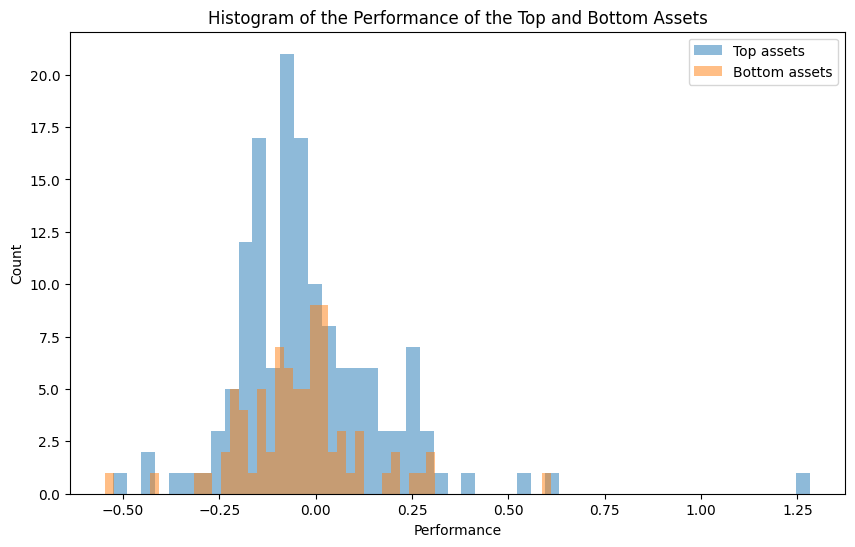

In [10]:
####################################################################################
######################## Analyze Optimized Parameter  ###############################
####################################################################################
#I 2023-07-31 07:33:33,960] Trial 218 finished with value: 216.35758672222224 and parameters: {'lookback_period': 480, 'forecast_period': 108, 'percentage': 1}. Best is trial 218 with value: 216.35758672222224.

lookback_period = 480 * 3600 #study.best_params['lookback_period'] * 3600
forecast_period = 108 * 3600 #study.best_params['forecast_period'] * 3600
percentage = 1 #study.best_params['percentage']
window = 108 * 3600


# Function to calculate the price change rate
def calculate_change_rate(df):
    return (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]

# Initialize lists to store the performance of the top and bottom assets
top_performance = []
bottom_performance = []

# Iterate over each window
for ts in range(start_ts, end_ts - forecast_period, window):
    # Initialize a dictionary to store the change rate of each asset in the lookback period
    change_rates = {}

    # Calculate the change rate for each asset
    for asset, df in dataframes.items():
        df_in_window = df[(df['timestamp'] >= ts) & (df['timestamp'] < ts + lookback_period)]
        if len(df_in_window) > 0:
            change_rate = calculate_change_rate(df_in_window)
            if not np.isnan(change_rate):
                change_rates[asset] = change_rate

    # Rank the assets by the change rate
    ranked_assets = sorted(change_rates.items(), key=lambda x: x[1])

    # Get the top and bottom assets
    num_assets = len(ranked_assets)
    top_assets = ranked_assets[int((1 - percentage / 100) * num_assets):]
    bottom_assets = ranked_assets[:int(percentage / 100 * num_assets)]

    # Calculate the performance of the top and bottom assets in the forecast period
    for asset, _ in top_assets:
        df_in_window = dataframes[asset][(dataframes[asset]['timestamp'] >= ts + lookback_period) & (dataframes[asset]['timestamp'] < ts + lookback_period + forecast_period)]
        if len(df_in_window) > 0:
            performance = calculate_change_rate(df_in_window)
            if not np.isnan(performance):
                top_performance.append(performance)

    for asset, _ in bottom_assets:
        df_in_window = dataframes[asset][(dataframes[asset]['timestamp'] >= ts + lookback_period) & (dataframes[asset]['timestamp'] < ts + lookback_period + forecast_period)]
        if len(df_in_window) > 0:
            performance = calculate_change_rate(df_in_window)
            if not np.isnan(performance):
                bottom_performance.append(performance)

# Calculate the average performance of the top and bottom assets
average_top_performance = np.mean(top_performance)
average_bottom_performance = np.mean(bottom_performance)


print('lookback period:', lookback_period / 3600, ' hrs')
print('forecast period:', forecast_period / 3600, ' hrs')
print('selection percentage:', percentage, '%')
print('start-ts:', datetime.fromtimestamp(start_ts))
print('end_ts:', datetime.fromtimestamp(end_ts))
print('Average top performance:', average_top_performance)
print('Average bottom performance:', average_bottom_performance)
er = round(100 * (max(average_top_performance, average_bottom_performance) - min(average_top_performance, average_bottom_performance)), 6)
print('Expected Ave Return:', er, '%')
print('Expected Total Return:', er * (end_ts - start_ts  - lookback_period) / forecast_period)


# Plot the histogram of the performance of the top and bottom assets
plt.figure(figsize=(10, 6))
plt.hist(top_performance, bins=50, alpha=0.5, label='Top assets')
plt.hist(bottom_performance, bins=50, alpha=0.5, label='Bottom assets')
plt.legend(loc='upper right')
plt.xlabel('Performance')
plt.ylabel('Count')
plt.title('Histogram of the Performance of the Top and Bottom Assets')
plt.show()

In [6]:
####################################################################################
######################## Simulate Trading  ###############################
####################################################################################


class Sim:
    def __init__(self):
        self.num_trade = 0
        self.num_win = 0
        self.win_ratio = 0
        self.total_cash = 10000
        self.realized_pnl = 0
        self.fee_ratio = 0.0007
        self.positions = {} #symbol:long(1) or short(-1)
        self.position_size = {} #symbol:size
        self.position_entry_price = {} #symbol:price
        self.total_holding_amount = 0
        self.total_fee = 0
        self.total_assets = []
        self.start_ts_act = ''
        self.end_ts_act = ''

    def start_sim(self, dataframes, start_ts, end_ts, lookback_period, forecast_period, percentage, top_bottom_ls, display:bool):
        dataframes = self.__preprocess_data(dataframes, start_ts, end_ts)
        if display:
            print('#target symbol=', len(dataframes))
        current_ts = start_ts + lookback_period * 3600
        # Get index of timestamp matched with current_ts of first symbol
        symbol = list(dataframes.keys())[0] # get the first symbol
        current_ind = dataframes[symbol][dataframes[symbol]['timestamp'] == current_ts].index[0]
        holding_period = 0
        self.start_ts_act = current_ts
        while current_ts < end_ts + forecast_period:
            if len(self.positions) == 0:
                top_symbols, bottom_symbols = self.__get_top_bottom_symbols(dataframes, current_ind, current_ts, lookback_period, percentage)
                self.__entry_trade(current_ind, dataframes, top_symbols, bottom_symbols, top_bottom_ls)
                holding_period = 0
            else:
                holding_period += 1
                if holding_period >= forecast_period:
                    self.__exit_positions(current_ind, dataframes)
            self.total_assets.append(self.__update_total_asset(current_ind, dataframes))
            current_ind += 1
            if len(list(dataframes.values())[0]) > current_ind:
                current_ts = list(dataframes.values())[0].iloc[current_ind]['timestamp']
            else:
                self.end_ts_act = current_ts
                break
        if display:
            self.__display_results()

    def __display_results(self):
        total_return_ratio = round(self.total_assets[-1] / self.total_cash, 6)
        print(f'Sim Period Length: {(self.end_ts_act - self.start_ts_act) / 3600} hrs')
        print(f"Number of trades: {self.num_trade}")
        print(f"Total return: {round(self.total_assets[-1] / self.total_cash, 6)}")
        print(f"Ave Monthly Return: { self.total_assets[-1] / self.total_cash / (self.end_ts_act - self.start_ts_act) / (3600 * 24 * 30) }")
        print(f"Win ratio: {self.num_win / self.num_trade if self.num_trade != 0 else 0}")
        print(f'Total Cash: {self.total_cash}')
        # chart of total assets
        pd.Series(self.total_assets).plot()


    def __preprocess_data(self, dataframes, start_ts, end_ts):
        preprocessed_dataframes = {}
        df = dataframes['bybit-BTC-USDT']
        edf = df[(df['timestamp'] >= start_ts) & (df['timestamp'] <= end_ts)]
        kijun = list(edf['timestamp'])
        for k in list(dataframes.keys()):
            dff = dataframes[k][(dataframes[k]['timestamp'] >= start_ts) & (dataframes[k]['timestamp'] <= end_ts)]
            if len(dff) ==0 or kijun != list(dff['timestamp']):
                #print('inconsistent-',k, len(kijun), len(list(dff['timestamp'])))
                pass
            else:
                preprocessed_dataframes[k] = dff.reset_index(drop=True)
        return preprocessed_dataframes


    def __get_top_bottom_symbols(self, dataframes, current_ind, current_ts, lookback_period, percentage):
        lookback_period_performance = {} #symbol:performance
        for symbol, df in dataframes.items():
            lookback_period_performance[symbol] = (df.iloc[current_ind]['close'] - df.iloc[current_ind - lookback_period]['close']) / df.iloc[current_ind - lookback_period]['close']
        # Rank the symbol by the performance
        sorted_symbols = sorted(lookback_period_performance.items(), key=lambda x:x[1])
        num_symbols = len(sorted_symbols)
        # Get the top and bottom symbol using percentage
        top_symbols = sorted_symbols[int((1-percentage)*num_symbols):]
        bottom_symbols = sorted_symbols[:int(percentage*num_symbols)]
        return [item[0] for item in top_symbols], [item[0] for item in bottom_symbols]


    def __entry_trade(self, current_ind, dataframes, top_symbols, bottom_symbols, top_bottom_ls):
        #calc size for symbols
        ave_amount = self.total_cash / (len(top_symbols) + len(bottom_symbols))
        for top_symbol in top_symbols:
            self.positions[top_symbol] = top_bottom_ls['top']
            self.position_size[top_symbol] = ave_amount / dataframes[top_symbol].iloc[current_ind]['close']
            self.position_entry_price[top_symbol] = dataframes[top_symbol].iloc[current_ind]['close']
            #self.total_cash -= self.position_size[top_symbol] * self.position_entry_price[top_symbol]
            self.total_holding_amount += self.position_size[top_symbol] * self.position_entry_price[top_symbol]
            self.total_fee += self.fee_ratio * (self.position_size[top_symbol] * self.position_entry_price[top_symbol]) /100.0
        for bottom_symbol in bottom_symbols:
            self.positions[bottom_symbol] = top_bottom_ls['bottom']
            self.position_size[bottom_symbol] = ave_amount / dataframes[bottom_symbol].iloc[current_ind]['close']
            self.position_entry_price[bottom_symbol] = dataframes[bottom_symbol].iloc[current_ind]['close']
            #self.total_cash -= self.position_size[bottom_symbol] * self.position_entry_price[bottom_symbol]
            self.total_holding_amount += self.position_size[bottom_symbol] * self.position_entry_price[bottom_symbol]
            self.total_fee += self.fee_ratio * (self.position_size[bottom_symbol] * self.position_entry_price[bottom_symbol]) / 100.0

    def __exit_positions(self, current_ind, dataframes):
        realized_pnl = 0
        for symbol in self.positions:
            if self.positions[symbol] == 1:
                realized_pnl += self.position_size[symbol] * (dataframes[symbol].iloc[current_ind]['close'] - self.position_entry_price[symbol])
            else:
                realized_pnl += self.position_size[symbol] * (self.position_entry_price[symbol] - dataframes[symbol].iloc[current_ind]['close'])
            #self.total_cash += self.position_size[symbol] * dataframes[symbol].iloc[current_ind]['close']
            self.total_fee += self.fee_ratio * (self.position_size[symbol] * dataframes[symbol].iloc[current_ind]['close']) / 100.0
        self.realized_pnl += realized_pnl
        if realized_pnl > 0:
            self.num_win += 1
        self.num_trade += 1
        self.win_rate = self.num_win / self.num_trade
        self.total_holding_amount = 0
        self.positions = {}
        self.position_size = {}
        self.position_entry_price = {}


    #total_asset = cash + unrealized_pnl - total_fee
    def __update_total_asset(self, current_ind, dataframes):
        unrealized_pnl = 0
        for symbol in self.positions:
            if self.positions[symbol] == 1:
                unrealized_pnl += self.position_size[symbol] * (dataframes[symbol].iloc[current_ind]['close'] - self.position_entry_price[symbol])
            else:
                unrealized_pnl += self.position_size[symbol] * (self.position_entry_price[symbol] - dataframes[symbol].iloc[current_ind]['close'])
        #return self.realized_pnl + self.total_cash + self.total_holding_amount + unrealized_pnl - self.total_fee
        return self.realized_pnl + unrealized_pnl - self.total_fee


#target symbol= 170
Sim Period Length: 6709.0 hrs
Number of trades: 15
Total return: 0.162457
Ave Monthly Return: 2.595042240116268e-15
Win ratio: 0.6
Total Cash: 10000


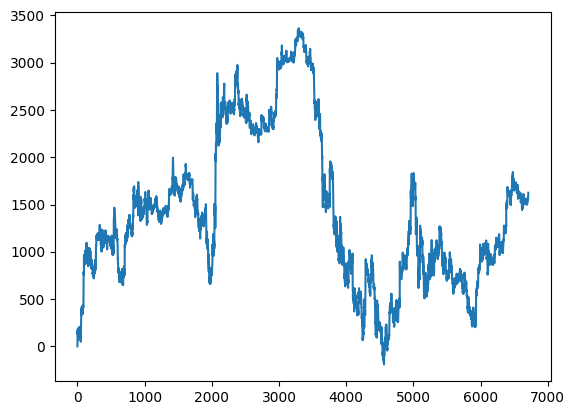

In [7]:
#869] Trial 287 finished with value: 0.1391475924182191 and parameters: {'lookback_period': 471, 'forecast_period': 25, 'percentage': 7}. Best is trial 287 with value: 0.1391475924182191.
#7,647] Trial 259 finished with value: 0.1887535011955889 and parameters: {'lookback_period': 264, 'forecast_period': 35, 'percentage': 8}. Best is trial 259 with value: 0.1887535011955889.
#8,566] Trial 41 finished with value: 0.1981408373170765 and parameters: {'lookback_period': 289, 'forecast_period': 445, 'percentage': 5}. Best is trial 41 with value: 0.1981408373170765.

top_bottom_ls = {'top':1, 'bottom':-1}
lookback_period = 289
forecast_period = 445
percentage = 5
#start_ts = 1684688400
#end_ts = 1690586000
sim = Sim()
sim.start_sim(dataframes, start_ts, end_ts, int(lookback_period), int(forecast_period), percentage, top_bottom_ls, True)

In [ ]:
####################################################################################
######################## Optimize Parameters for Top Bottom Sim ###############################
####################################################################################

class StrategyOptimizer:
    def __init__(self, dataframes, start_ts, end_ts):
        self.dataframes = dataframes
        self.start_ts = start_ts
        self.end_ts = end_ts


    def calculate_change_rate(self, df):
        return (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]

    def strategy_performance(self, lookback_period, forecast_period, percentage):
        top_bottom_ls = {'top':1, 'bottom':-1}
        sim = Sim()
        sim.start_sim(dataframes, start_ts, end_ts, int(lookback_period/3600), int(forecast_period/3600), percentage, top_bottom_ls, False)
        return sim.total_assets[-1] / sim.total_cash


def read_data():
    dataframes = {}
    print('Reading files..')
    for filename in os.listdir(directory):
        if 'USDT' in filename and filename.endswith('.csv'):
            try:
                asset = filename[:-4]
                df = pd.read_csv(os.path.join(directory, filename))
                df = df.sort_values('timestamp')
                df['timestamp'] = df['timestamp'] / 1000  # Convert from ms to s
                dataframes[asset] = df
            except pd.errors.EmptyDataError:
                print('skipping ', filename, ' as it is empty.')
            except Exception as e:
                print('An unexpected error occurred whil reading ', filename)
    print('Complated Read all data. #=', len(dataframes))
    return dataframes


def get_start_end_ts(dataframes):
    # Get the start and end timestamps for each asset
    start_timestamps = [df['timestamp'].min() for df in dataframes.values()]
    end_timestamps = [df['timestamp'].max() for df in dataframes.values()]
    # Convert to numpy arrays
    start_timestamps = np.array(start_timestamps)
    end_timestamps = np.array(end_timestamps)
    # Calculate the threshold for the top 5% and bottom 5%
    start_threshold = np.percentile(start_timestamps, 5)
    end_threshold = np.percentile(end_timestamps, 95)
    # Set the start and end timestamps as the thresholds, and convert to integers
    start_ts = int(start_threshold)
    end_ts = int(end_threshold)
    return start_ts, end_ts

def save_results(study, trial):
    # 結果をDataFrameに保存
    df = study.trials_dataframe()
    # 結果をCSVに追加的に書き込む
    #df.to_csv(directory+'/optuna_results.csv', mode='a', header=False)

# Create a study object and optimize the objective function
def objective(trial, dataframes, start_ts, end_ts):
    # Suggest values for the parameters
    # Assuming that the OHLC data is in 1-hour intervals (3600 seconds)
    lookback_period_hours = trial.suggest_int('lookback_period', 24, 480)  # 24 to 72 hours
    forecast_period_hours = trial.suggest_int('forecast_period', 24, 480)  # 24 to 72 hours
    window_hours = 24 #trial.suggest_int('window', 24, 72)  # 24 to 72 hours
    percentage = trial.suggest_int('percentage', 1, 10)

    # Convert hours to seconds
    lookback_period = lookback_period_hours * 3600
    forecast_period = forecast_period_hours * 3600
    window = window_hours * 3600

    optimizer = StrategyOptimizer(dataframes, start_ts, end_ts)

    return optimizer.strategy_performance(lookback_period, forecast_period, percentage)





dataframes = read_data()
start_ts, end_ts = get_start_end_ts(dataframes)
end_ts = 1690586000
print('start ts=', datetime.fromtimestamp(start_ts))
print('end ts=', datetime.fromtimestamp(end_ts))

study = optuna.create_study(direction='maximize')
#study.optimize(objective(dataframes, start_ts, end_ts), n_trials=100, n_jobs=-1)  # Use all available CPU cores
study.optimize(lambda trial: objective(trial, dataframes, start_ts, end_ts), n_trials=300, n_jobs=-1, callbacks=[save_results])  # Use all available CPU cores


# Print the best parameters
print(study.best_params)




Reading files..
skipping  bybit-HIGH-USDT.csv  as it is empty.


[I 2023-08-02 04:52:14,392] A new study created in memory with name: no-name-23cc3cf9-8e05-408b-b0e0-163a8fc174fa


Complated Read all data. #= 226
start ts= 2022-08-03 03:00:00
end ts= 2023-07-28 23:13:20


[I 2023-08-02 04:54:34,130] Trial 0 finished with value: 0.16098167621014126 and parameters: {'lookback_period': 223, 'forecast_period': 312, 'percentage': 8}. Best is trial 0 with value: 0.16098167621014126.
[I 2023-08-02 04:54:46,057] Trial 1 finished with value: 0.1602930593240932 and parameters: {'lookback_period': 180, 'forecast_period': 59, 'percentage': 8}. Best is trial 0 with value: 0.16098167621014126.
[I 2023-08-02 04:56:50,371] Trial 2 finished with value: 0.14784083701600442 and parameters: {'lookback_period': 300, 'forecast_period': 463, 'percentage': 7}. Best is trial 0 with value: 0.16098167621014126.
[I 2023-08-02 04:57:16,238] Trial 3 finished with value: 0.1237404388976547 and parameters: {'lookback_period': 107, 'forecast_period': 104, 'percentage': 4}. Best is trial 0 with value: 0.16098167621014126.
[I 2023-08-02 04:59:12,199] Trial 4 finished with value: 0.12934135405777195 and parameters: {'lookback_period': 180, 'forecast_period': 153, 'percentage': 5}. Best is

In [23]:
dataframes['bybit-ARKM-USDT']['timestamp']

0     1.690510e+09
1     1.690513e+09
2     1.690517e+09
3     1.690520e+09
4     1.690524e+09
5     1.690528e+09
6     1.690531e+09
7     1.690535e+09
8     1.690538e+09
9     1.690542e+09
10    1.690546e+09
11    1.690549e+09
12    1.690553e+09
13    1.690556e+09
14    1.690560e+09
15    1.690564e+09
16    1.690567e+09
17    1.690571e+09
18    1.690574e+09
19    1.690578e+09
20    1.690582e+09
21    1.690585e+09
22    1.690589e+09
23    1.690592e+09
24    1.690596e+09
Name: timestamp, dtype: float64

In [8]:
end_ts

1684688400